<a href="https://colab.research.google.com/github/paigeyeung/exowatch-colab/blob/master/SearchVSXfromFITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Notebook code to read in a FITS file that has already been plate solved and look for variable stars 
# in the VSX database in the field and then to find AAVSO comp stars in the field. 
# The results are displayed on the image
#
# Definitions
#
# The csv file with the star list
InputFITS = '/content/drive/MyDrive/The Clusterminators/Images/LCOGTOHSInStAR/2021_Clusters/Terzan3/Terzan3_V_2459264d8006508658_2021d02d19T07d10d45d697_1a5661079_300d284_kb26_OHSInStAR (1).fit'

# pixelScale is the width of a pixel in arcseconds. It will be used to calculate the search size.
# If you don't know it, set it to zero or a negative number and 
# the search size will use the SearchSize parameter
pixelScale = 0

# SearchSize is the comp field in arcminutes (30 corresponds to Chart Field E). 
# It is only used if pixelScale is not set
SearchSize = 35

# MagLimit is the maximum magnitude for plotting variable stars 
MagLimit = 13.5

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# definition of a function to use the VSX API and parse the VOTABLE results
# this code comes from a note posted Sat, 12/15/2018 - 13:55 in the AAVSO forums by stratis (Nigel Banks, Worcester, GB)
# the code was slightly modified by Daniel Zaharevitz 1/2021 to make it run under python 3
# it would probably be worth checking into using the astroquery library to do the VOTABLE parsing to have 
# better maintained code

# get_vsx_data
#
# Returns the results of a query to the AAVSO VSX API to retrieve target data.
#
# Input:    url         VSX API url. Defaults to http://www.aavso.org/vsx/index.php
#           params      VSX API query parameters. Defaults to query.votable view.
#                       Additional parameters defined here: https://www.aavso.org/direct-web-query-vsxvsp
#
# Output:   List of dictionary objects with one dictionary per target (star)
#           returned by the VSX API. Dictionaries keyed by the VSX field id. 
#
# This function uses the BeautifulSoup HTTP/XML parser:
from bs4 import BeautifulSoup as bs
import requests
from io import StringIO

def get_vsx_data(url = "http://www.aavso.org/vsx/index.php",
                 params = {'view': 'query.votable',
                           'vtype': 'ep'}   # ep for test purposes only to limit results
                          ):
    
    response = requests.get(url,params=params)
    if (response.status_code > 400):
        raise Exception(response.status_code, response.reason)
    votableXML = StringIO()        # Create in-memory file
    votableXML.write(response.text)   # Save response to in-memory file
    soup = bs(votableXML.getvalue(), "xml") # Parse using BeautifulSoup

    # Load field definitions, checking for missing or duplicate ids
    fields = soup.find_all("FIELD")
    for field in fields:
        if field["id"] is None:
            raise Exception("Field has no id.")
        elif len(soup.select('FIELD[id=%s]' % field["id"])) != 1:
            raise Exception("Duplicate field id.")

    # Build list of dictionaries, one dict per row (star), indexed by field id
    rows = soup.find_all("TR")
    results = []
    for row in rows:
        row_dict = {}
        row_fields = row.find_all("TD")
        if len(row_fields) != len(fields):
            # No. of TD elements in row should always == no. of FIELD elements
            raise Exception("Field and TD numbers differ.")
        fieldNum = 0
        for row_field in row_fields:
            row_dict[fields[fieldNum]["id"]] = str(row_field.string)
            fieldNum += 1
        results.append(row_dict)
        row_dict = None
    return(results)


In [ ]:
# Imports for the searches
import sys
import csv
import urllib.request
import urllib.parse
import requests
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SquaredStretch
import numpy as np


In [ ]:
# Do a location search in VSX using the center of the field


infits = fits.open(InputFITS)
wrld = WCS(infits[0].header)


fdims = wrld.pixel_shape
mind = fdims[0]
if fdims[1] < mind:
    mind = fdims[1]
if pixelScale > 0:
    searchbox = int(((mind*pixelScale)/60) - 1)
else:
    searchbox = SearchSize
if searchbox > 300:
    searchbox = 300
xcenterpix = fdims[0]/2
ycenterpix = fdims[1]/2
centercoords = wrld.pixel_to_world(xcenterpix,ycenterpix)
centerRA = centercoords.ra.degree
centerDec = centercoords.dec.degree
url = 'http://www.aavso.org/vsx/index.php'
data = {}
data['view'] = 'query.votable'
data['filter'] = '0,1'


# Search by the given coordinates
data['format'] = 'd'
data['geom'] = 'b'
data['size'] = searchbox
data['order'] = '9'
data['coords'] = centercoords.to_string('decimal')
resj = get_vsx_data(url,params=data)
if len(resj) > 0:
    varStarList = []
    for star in resj:
        StarName = 'no match'
        VSX_UID = 'no match'
        vcoords = 'no match'
        for k,v in star.items():
            if k == 'name':
                StarName = v
            if k == 'auid':
                VSX_UID = v
            if k == 'maxMag':
                VSX_Mag = v
            if k == 'maxPass':
                VSX_Band = v
            if k == 'radec2000':
                vcoords = v.split(",")
            if k == 'varType':
                varType = v
        skystar = SkyCoord(vcoords[0], vcoords[1], frame='fk5', unit='deg')
        stary, starx = wrld.world_to_array_index(skystar)
        thisStar = {}
        thisStar['StarName'] = StarName
        thisStar['FITS_x'] = starx
        thisStar['FITS_y'] = stary
        thisStar['AUID'] = VSX_UID
        thisStar['RA'] = vcoords[0]
        thisStar['Dec'] = vcoords[1]
        thisStar['mag'] = VSX_Mag
        thisStar['band'] = VSX_Band
        thisStar['varType'] = varType
        varStarList.append(thisStar)
        print(thisStar)
                


{'StarName': 'ASASSN-V J162838.83-352018.9', 'FITS_x': 1412, 'FITS_y': 1037, 'AUID': 'None', 'RA': '247.16181000', 'Dec': '-35.33858000', 'mag': '14.080', 'band': 'V', 'varType': 'L'}
{'StarName': 'ASASSN-V J162842.37-351607.1', 'FITS_x': 973, 'FITS_y': 1117, 'AUID': 'None', 'RA': '247.17656000', 'Dec': '-35.26863000', 'mag': '13.610', 'band': 'V', 'varType': 'SR'}
{'StarName': 'ASASSN-V J162800.44-351854.9', 'FITS_x': 1257, 'FITS_y': 218, 'AUID': 'None', 'RA': '247.00183000', 'Dec': '-35.31525000', 'mag': '14.340', 'band': 'V', 'varType': 'SR'}
{'StarName': 'ASASSN-V J162917.61-352859.9', 'FITS_x': 2330, 'FITS_y': 1854, 'AUID': 'None', 'RA': '247.32336000', 'Dec': '-35.48330000', 'mag': '14.750', 'band': 'V', 'varType': 'SR'}
{'StarName': 'ASASSN-V J162751.25-351407.2', 'FITS_x': 753, 'FITS_y': 26, 'AUID': 'None', 'RA': '246.96356000', 'Dec': '-35.23534000', 'mag': '12.590', 'band': 'V', 'varType': 'ROT'}
{'StarName': 'ASASSN-V J162941.78-352145.6', 'FITS_x': 1578, 'FITS_y': 2379, 'AU

In [ ]:
# Search for comp stars
data = {}
data['format'] = 'json'
data['fov'] = searchbox
data['ra'] = centerRA
data['dec'] = centerDec
data['maglimit'] = MagLimit

url = 'https://app.aavso.org/vsp/api/chart/'
url_values = urllib.parse.urlencode(data)
full_url = url + '?' + url_values
respj = requests.get(full_url)
resj = respj.json()
list(resj)
CheckError = resj.get('errors','No Errors') 
if CheckError != 'No Errors':
    print('Search Error')
else:
    kval = resj.get('photometry')
    CompStarList = []
    CompStarXY = []
    for compk in kval:
            compRA = compk.get('ra')
            compDEC = compk.get('dec')
            compAUID = compk.get('auid')
            compLabel = compk.get('label')
            skystar = SkyCoord(compRA, compDEC, frame='fk5',unit=(u.hourangle,u.deg))
            stary, starx = wrld.world_to_array_index(skystar)
            compv = compk.get('bands')
            for bandk in compv:
                    if bandk.get('band') == 'V':
                        Vmag = float(bandk.get('mag'))
                    if bandk.get('band') == 'B':
                        Bmag = float(bandk.get('mag'))
            thisComp = {}
            thisComp['Label'] = compLabel
            thisComp['AUID'] = compAUID
            thisComp['FITS_x'] = starx
            thisComp['FITS_y'] = stary
            thisComp['RA'] = compRA
            thisComp['Dec'] = compDEC
            thisComp['Vmag'] = Vmag
            thisComp['Bmag'] = Bmag
            thisXY = [starx,stary]
            CompStarXY.append(thisXY)
            CompStarList.append(thisComp)
            print(thisComp)
    print(" ")
    print("Comp star XY list ")
    print(CompStarXY)

print(" ")
print(" ")
print("******************************")
print("End of Comp Star list")
print("******************************")


 
Comp star XY list 
[]
 
 
******************************
End of Comp Star list
******************************


Variable: 753, 26
Variable: 33, 47
Variable: -299, 1888
Variable: 3033, 2451


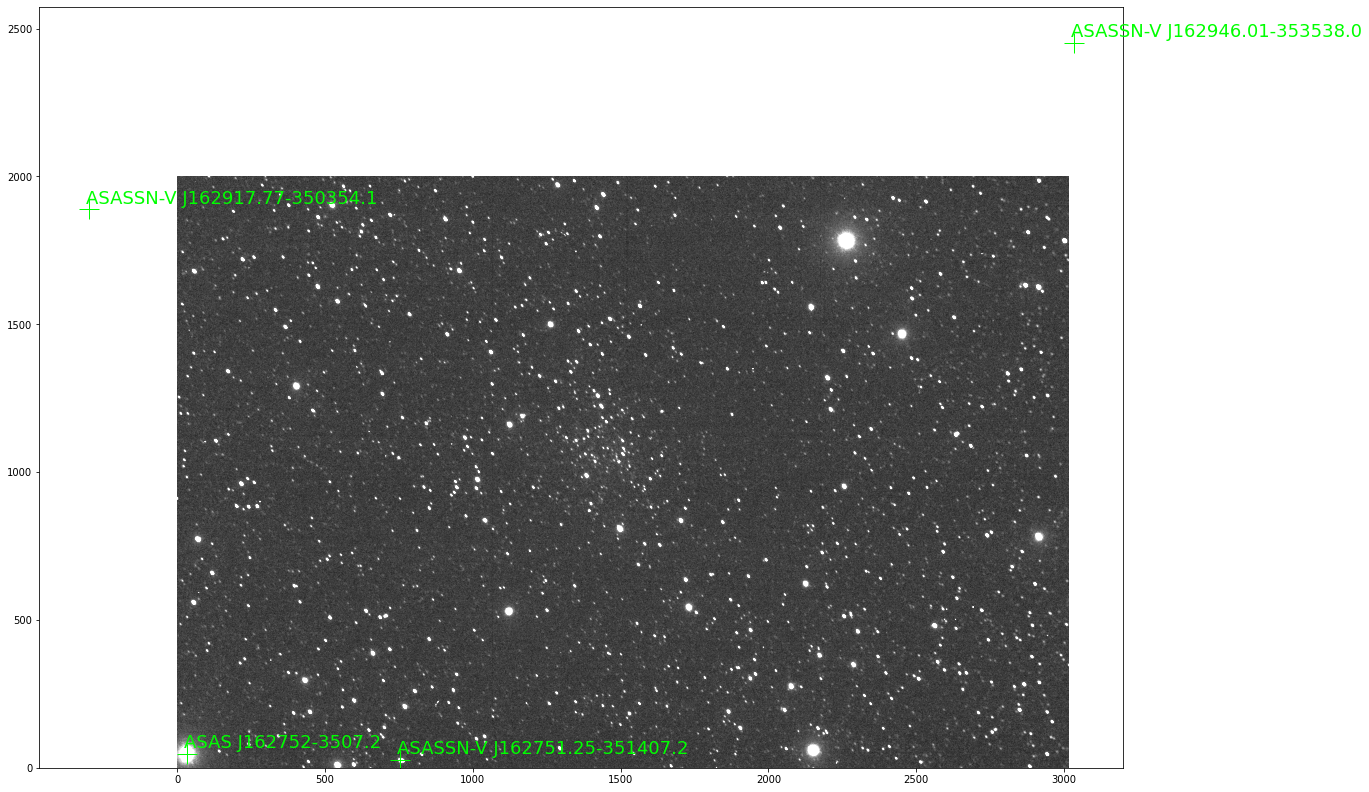

In [ ]:
# Display the FITS image and add annotations for the stars found
ApSize = 50
image_data = infits[0].data
norm = ImageNormalize(image_data, interval=ZScaleInterval(), stretch=SquaredStretch())
fig = plt.figure(figsize=(21,14))
ax = fig.add_subplot(111)
plt.imshow(image_data, norm=norm, origin='lower', cmap='Greys_r', interpolation=None)
for thisStar in varStarList:
    if float(thisStar.get('mag')) < MagLimit:
        xpos = thisStar.get('FITS_x')
        ypos = thisStar.get('FITS_y')
        ylabel = ypos + 21
        xlabel = xpos - 10
        ax.plot(xpos, ypos, marker='+',color='lime', ms=20)
        ax.text(xlabel, ylabel, thisStar.get('StarName'), color = 'lime', fontsize=18)
        print(f"Variable: {xpos}, {ypos}")
for thisStar in CompStarList:
        xpos = thisStar.get('FITS_x')
        ypos = thisStar.get('FITS_y')
        print(f"Comp: {xpos}, {ypos}")
        ylabel = ypos + 20
        xlabel = xpos - 10
        ax.plot(xpos, ypos, marker='+',color='red', ms=20)
        ax.text(xlabel, ylabel, thisStar.get('Label'), color = 'red', fontsize=12, fontweight='bold')